<a href="https://colab.research.google.com/github/lucas-fpaiva/AnalisePred_I/blob/main/Projeto/popularity_forro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliar a popularidade de músicas de forro

In [1]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_classification



In [2]:
forroset= pd.read_parquet('https://github.com/lucas-fpaiva/Forroset/blob/main/data/forroset.parq?raw=true', engine='auto')

In [3]:
forroset.columns

Index(['track_id', 'track', 'artist', 'artist_id', 'popularity', 'album',
       'album_id', 'track_year', 'duration_ms', 'uri', 'preview_url', 'energy',
       'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'loudness', 'valence', 'mode',
       'beats_start', 'beats_duration', 'beats_confidence', 'bars_start',
       'bars_duration', 'bars_confidence', 'tatums_start', 'tatums_duration',
       'tatums_confidence', 'librosa_beats_start', 'librosa_discrepancy',
       'tempo_bins', 'tempo_bins_max', 'genre_filt', 'folds', 'manual_filt',
       'lyrics'],
      dtype='object')

## Separando o treino e teste.

In [5]:
treino = forroset[forroset.folds>2][forroset.popularity>0]
teste = forroset[forroset.folds<3][forroset.popularity>0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
x_treino = treino[['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'loudness', 'valence', 'mode']]
y_treino = treino.popularity

x_teste = teste[['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'loudness', 'valence', 'mode']]
y_teste = teste.popularity

## Definindo função do GridSearchCV

In [55]:
def grid_best_model (model="DT", names=False, grid="", task="C"):
  #A função retorna o modelo com os melhores parametros, os melhores parametros e o melhor score
  
  #models = ["KNN","LM","DT","SVM", "RF", "MLP", "GB", "ADA"]
  #types = ["C","R"]
  if names == True:
    print("KNN: KNeighborsRegressor\nLM: LinearRegression\nDT: DecisionTreeRegressor\nRF: RandomForestRegressor",
          "\nGB: GradientBoostingRegressor\nSVM: SVR\nADA: AdaBoostRegressor\nMLP: MLPRegressor")
    
  if model == "DT":
    if task == "C":
      gs_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, cv= 5, scoring='accuracy')
      gs_cv.fit(x_treino, y_treino)
      return DecisionTreeClassifier(criterion=gs_cv.best_params_['criterion'], max_depth=gs_cv.best_params_['max_depth'], min_samples_leaf=gs_cv.best_params_['min_samples_leaf'], 
                                   n_estimators=gs_cv.best_params_['n_estimators'], random_state=gs_cv.best_params_['random_state']).fit(x_treino, y_treino)

    elif task == "R":
      gs_cv = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid, cv= 5, scoring='neg_mean_absolute_percentage_error')
      gs_cv.fit(x_treino, y_treino)
      return DecisionTreeRegressor(criterion=gs_cv.best_params_['criterion'], max_depth=gs_cv.best_params_['max_depth'], min_samples_leaf=gs_cv.best_params_['min_samples_leaf'],
                                   random_state=gs_cv.best_params_['random_state']).fit(x_treino, y_treino), gs_cv.best_params_, gs_cv.best_score_
        
  if model=="MLP":
    if task == "C":
      gs_cv = GridSearchCV(estimator=MLPClassifier(), param_grid=grid, cv= 5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return MLPClassifier(hidden_layer_sizes=gs_cv.best_params_['hidden_layer_sizes'], max_iter=gs_cv.best_params_['max_iter'], activation=gs_cv.best_params_['activation'], 
                           random_state=gs_cv.best_params_['random_state']), gs_cv.best_params_, gs_cv.best_score_
    elif task == "R":

      gs_cv = GridSearchCV(estimator=MLPRegressor(), param_grid=grid, cv= 5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
      gs_cv.fit(x_treino, y_treino)
      return MLPRegressor(hidden_layer_sizes=gs_cv.best_params_['hidden_layer_sizes'], max_iter=gs_cv.best_params_['max_iter'], activation=gs_cv.best_params_['activation'], 
                           random_state=gs_cv.best_params_['random_state']), gs_cv.best_params_, gs_cv.best_score_
    
  if model == "RF":
    if task == "C":
      gs_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5, scoring='neg_mean_absolute_percentage_error')
      gs_cv.fit(x_treino, y_treino)
      return RandomForestClassifier(n_estimators=gs_cv.best_params_['n_estimators'], max_depth=gs_cv.best_params_['max_depth'], max_features=gs_cv.best_params_['max_features'], 
                             random_state=gs_cv.best_params_['random_state'], criterion=gs_cv.best_params_['criterion']), gs_cv.best_params_, gs_cv.best_score_

    elif task == "R":
      gs_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5, scoring='neg_mean_absolute_percentage_error')
      gs_cv.fit(x_treino, y_treino)
      return RandomForestRegressor(n_estimators=gs_cv.best_params_['n_estimators'], max_depth=gs_cv.best_params_['max_depth'], max_features=gs_cv.best_params_['max_features'], 
                             random_state=gs_cv.best_params_['random_state'], criterion=gs_cv.best_params_['criterion']), gs_cv.best_params_, gs_cv.best_score_
        
  return print("KNN: KNeighborsRegressor\nLM: LinearRegression\nDT: DecisionTreeRegressor\nRF: RandomForestRegressor",
          "\nGB: GradientBoostingRegressor\nSVM: SVR\nADA: AdaBoostRegressor\nMLP: MLPRegressor")

## Definindo os parâmetros do GridSearchCV

In [ ]:
#Random Forest Classifier
# grid = { 
#     'n_estimators': [20,30,40,50],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth' : [5,10,15,20,25],
#     'criterion' :['gini', 'entropy'],
#     'random_state' : [0]
# }

In [59]:
#Random Forest Regressor
grid = { 
    'n_estimators': [20,30,40,50],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,10,15,20,25],
    'criterion' :['squared_error', 'absolute_error'],
    'random_state' : [0]
}

In [ ]:
#Multi Layer Perceptron Classifier
# grid = { 
#     'hidden_layer_sizes': [(10,10), (10,15)],
#     'max_iter': [10,15,20],
#     'activation' : ['relu'],
#     'random_state' : [0]
# }

In [42]:
#Multi Layer Perceptron Regressor
# grid = { 
#     'hidden_layer_sizes': [(10,10), (10,15)],
#     'max_iter': [10,15,20],
#     'activation' : ['relu'],
#     'random_state' : [0]
# }

In [ ]:
#Decision Tree Classifier
# grid = { 
#     'max_depth': [5,10,15,20,25],
#     'min_samples_leaf': [1,2,3,4,5],
#     'criterion' :['gini', 'entropy'],
#     'random_state' : [0]
# }

In [15]:
#Decision Tree Regressor
# grid = { 
#     'max_depth': [5,10,15,20,25],
#     'min_samples_leaf': [1,2,3,4,5],
#     'criterion' :['squared_error', 'absolute_error'],
#     'random_state' : [0]
# }

### Passando os parâmetros para a função Grid

In [57]:
model, best_parameters, best_score = grid_best_model("RF", False, grid, "R")

ValueError: ignored

#### Melhores parâmetros encontrados pelo GridSearchCV

In [44]:
best_parameters

{'activation': 'relu',
 'hidden_layer_sizes': (10, 10),
 'max_iter': 15,
 'random_state': 0}

#### Melhor score encontrado pelo GridSearchCV

In [45]:
best_score

-2.2563008817698518

### Predição do Modelo

In [48]:
model.fit(x_treino, y_treino)
np.sqrt(model.score(x_treino, y_treino))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


nan

In [49]:
model.score(x_teste, y_teste)

-0.1065487447201241

In [49]:
y_pred_t = model.predict(x_treino)

In [50]:
y_pred= model.predict(x_teste)

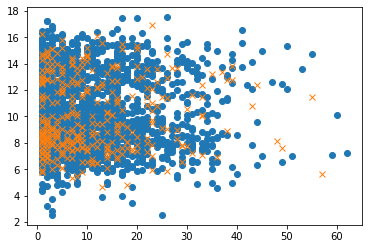

In [51]:
plt.plot(y_treino, y_pred_t, 'o')

plt.plot(y_teste, y_pred, 'x')


#### MAPE

In [52]:
mape(y_teste,y_pred)*100

200.0898208481693

200.0898208481693

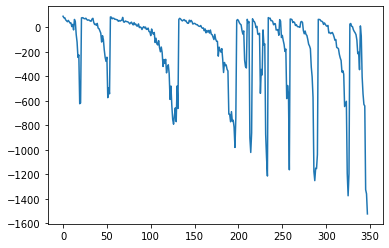

In [53]:
plt.plot(((y_teste.values - y_pred)/y_teste.values)*100)
np.mean(100*np.abs(y_teste.values - y_pred)/y_teste.values)

#### Plot do Modelo Teste x Treino

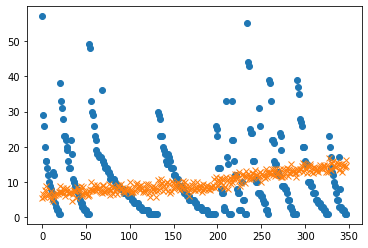

In [54]:
plt.plot(y_teste.values, 'o')
plt.plot(y_pred, 'x')

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.00001))) * 100

In [ ]:
def mae (y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def r2_score(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

0.24169303797468356